# Object masks in images from prompts with SAM 2

In [42]:
from mask_maker import *

import rawpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [43]:
def load_image_raw(path):
    """
    Charge une image RAW (.NEF) et retourne les données brutes du capteur
    sous forme de tableau numpy.
    """
    with rawpy.imread(path) as raw:
        raw_data = raw.raw_image_visible.copy().astype(np.float32)
    return raw_data


def demosaic_bilinear(raw_array):
    """
    Dématriçage bilinéaire simple d'un RAW Bayer RGGB.
    Retourne une image RGB numpy (H, W, 3).
    """
    h, w = raw_array.shape
    raw_array = raw_array.astype(np.float32)

    # Création des masques R, G, B
    R = np.zeros((h, w), dtype=np.float32)
    G = np.zeros((h, w), dtype=np.float32)
    B = np.zeros((h, w), dtype=np.float32)

    # Pattern RGGB
    R[0::2, 0::2] = raw_array[0::2, 0::2]
    G[0::2, 1::2] = raw_array[0::2, 1::2]
    G[1::2, 0::2] = raw_array[1::2, 0::2]
    B[1::2, 1::2] = raw_array[1::2, 1::2]

    # Noyaux bilinéaires pour interpolation
    kernel_RB = np.array([[0.25, 0.5, 0.25],
                          [0.5 , 1.0, 0.5 ],
                          [0.25, 0.5, 0.25]], dtype=np.float32)
    kernel_G = np.array([[0, 0.25, 0],
                         [0.25, 1.0, 0.25],
                         [0, 0.25, 0]], dtype=np.float32)

    # Convolution pour interpolation
    R_interp = convolve(R, kernel_RB, mode='mirror')
    G_interp = convolve(G, kernel_G, mode='mirror')
    B_interp = convolve(B, kernel_RB, mode='mirror')

    # Empilement final en float32
    rgb = np.stack((R_interp, G_interp, B_interp), axis=-1).astype(np.float32)

    return rgb


def show_raw_and_bilinear(raw_array):
    """
    Affiche :
    - à gauche : RAW brut (Bayer)
    - à droite : dématriçage bilinéaire simple
    """
    rgb = demosaic_bilinear(raw_array)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(raw_array, cmap='gray')
    axes[0].set_title("RAW brut (Bayer)")
    axes[0].axis("off")

    axes[1].imshow(rgb / rgb.max())
    axes[1].set_title("Dématriçage bilinéaire simple")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39434448..1.0].


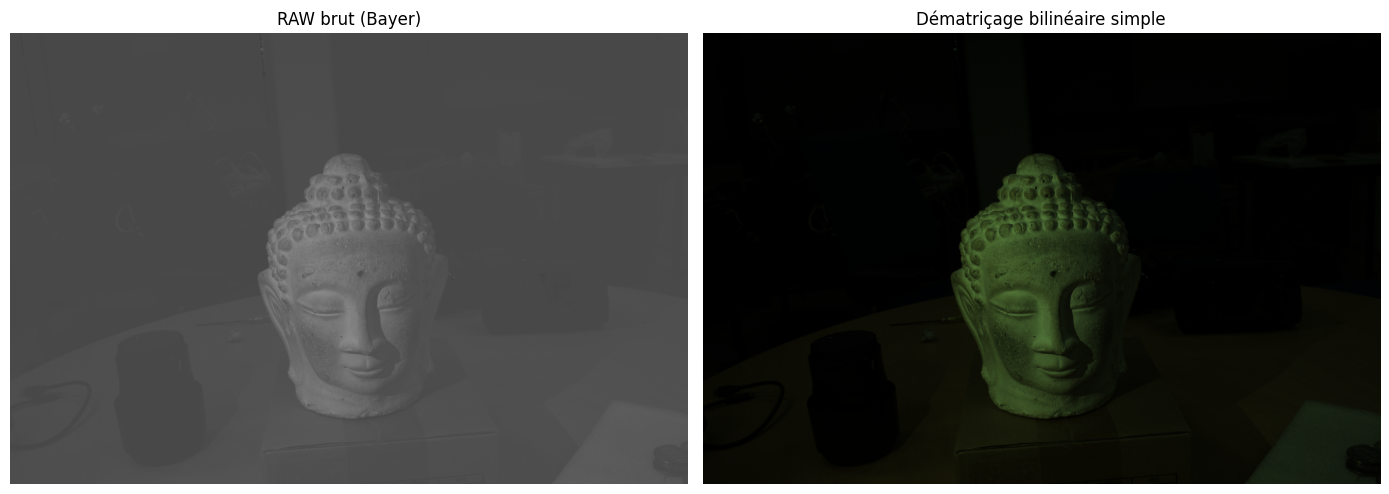

In [44]:
path_S = "./BDD/Reel/Buddha_4/Stray/DSC_9646.NEF"
S = load_image_raw(path_S)

path_SL = "./BDD/Reel/Buddha_4/Stray&PS/DSC_9653.NEF"
SL = load_image_raw(path_SL)

L_pred = SL - S
show_raw_and_bilinear(L_pred)


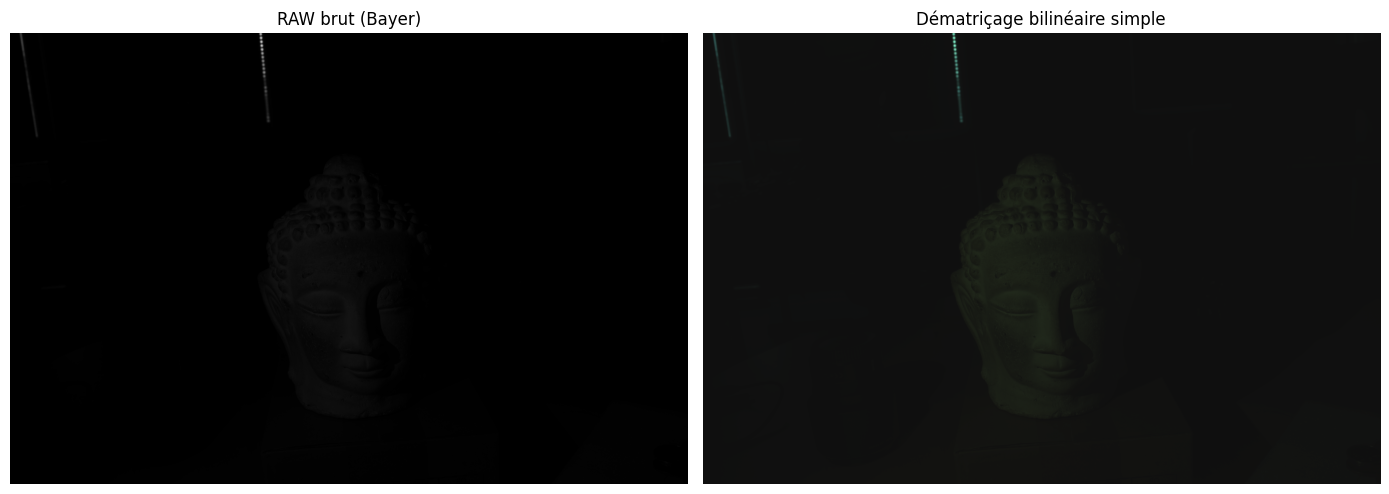

In [45]:
path_L = "./BDD/Reel/Buddha_4/PS/DSC_9505.NEF"
L_true = load_image_raw(path_L)

show_raw_and_bilinear(L_true)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12113433..1.0].


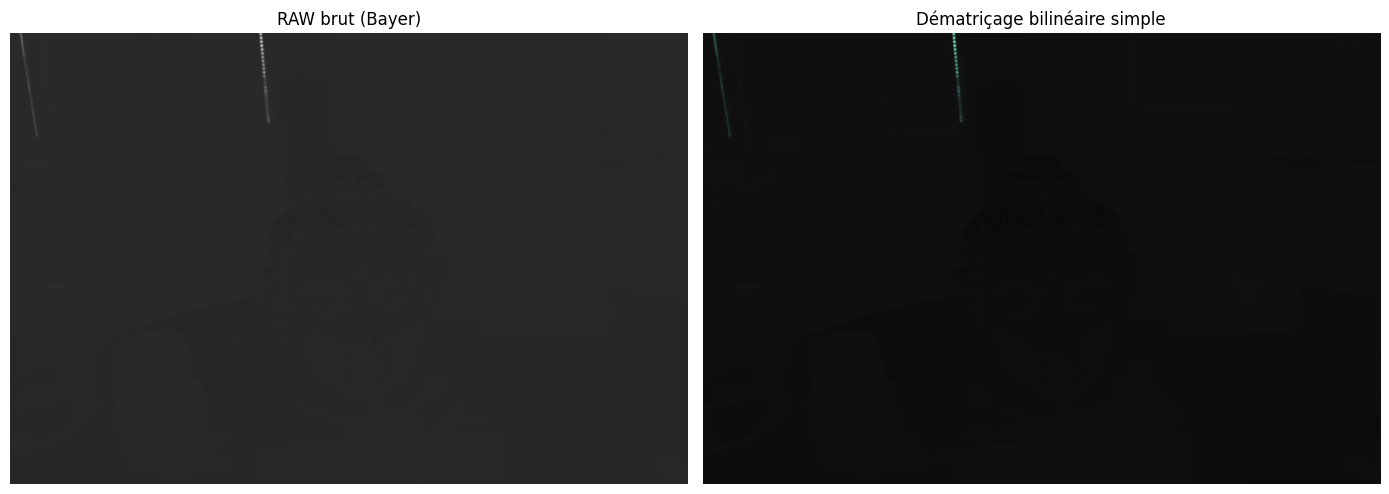

In [46]:
L_err = L_true - L_pred
show_raw_and_bilinear(L_err)